## Predicting Time Series
* simplest solution -> using TF OutputProjectionWrapper
* more advanced approach -> Fully Connected layer over the top of RNN


### Playing with RNN on the real world data (stock prices)

In [1]:
import investpy as iv
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# 035720 kakao 
# 096530 seazen
# 005930 samsung
counties = iv.get_stock_countries()
usd_history = iv.get_currency_cross_historical_data(currency_cross='USD/KRW',from_date='01/01/2018',to_date='10/01/2021') 
cny_history = iv.get_currency_cross_historical_data(currency_cross='CNY/KRW',from_date='01/01/2018',to_date='10/01/2021')


sm_stk_history = iv.get_stock_historical_data(stock='005930',country='south korea', from_date='01/01/2018', to_date='10/01/2021')
sm_stk_history = sm_stk_history.drop(columns=['Currency'])
sm_stk_history = sm_stk_history.astype(float)
min_max_scaler = MinMaxScaler()

# sm_stk_history[["Open", "High", "Low", "Close"]] = min_max_scaler.fit_transform(sm_stk_history[["Open", "High", "Low", "Close"]])
sm_stk_history /= 1000
# print(sm_stk_history)



#### RNN Based Approach (multi-layer RNN)

['Open', 'SMA_2', 'Low', 'High', 'Median', 'Close']


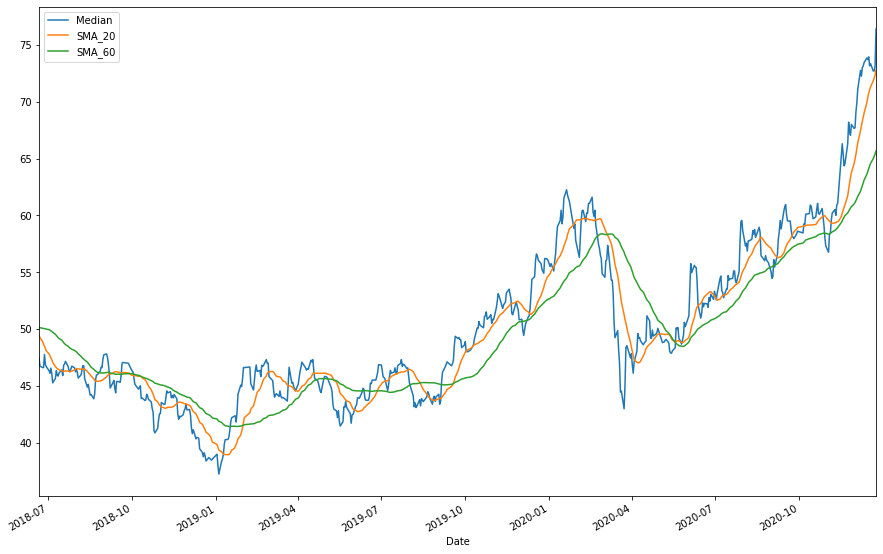

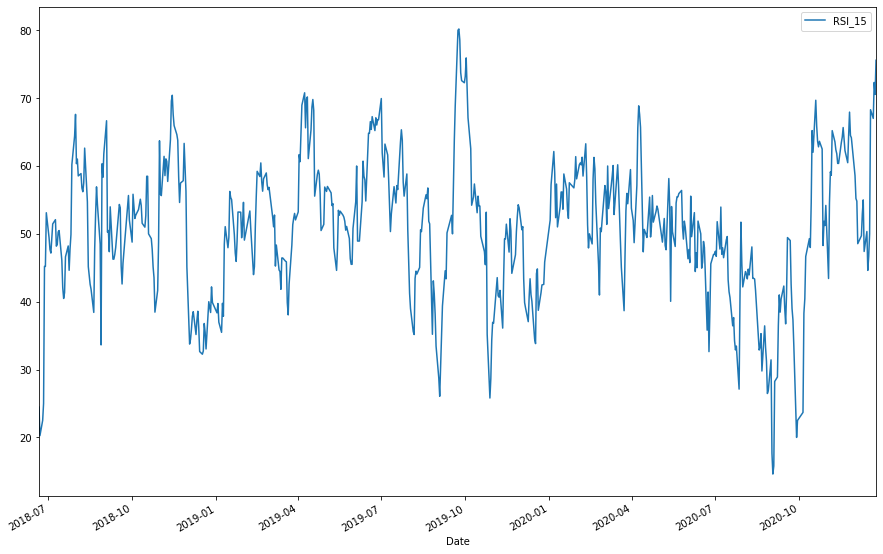

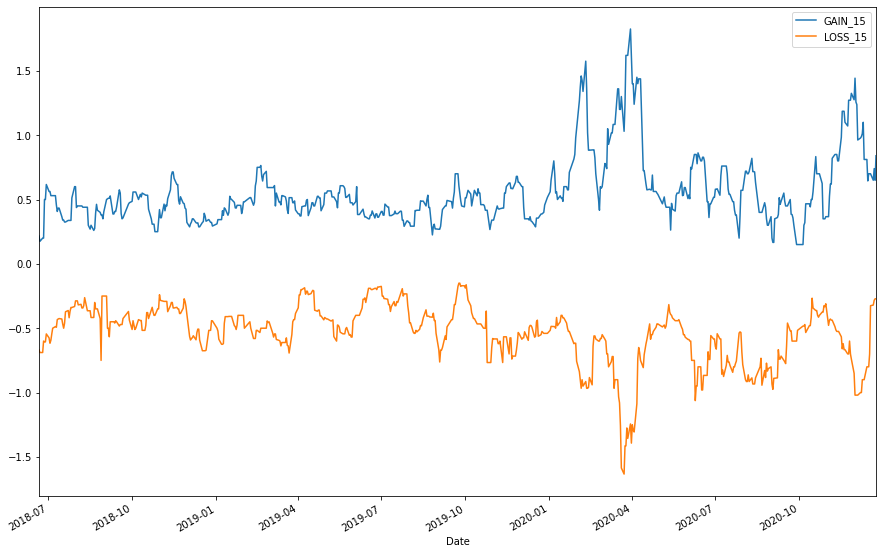

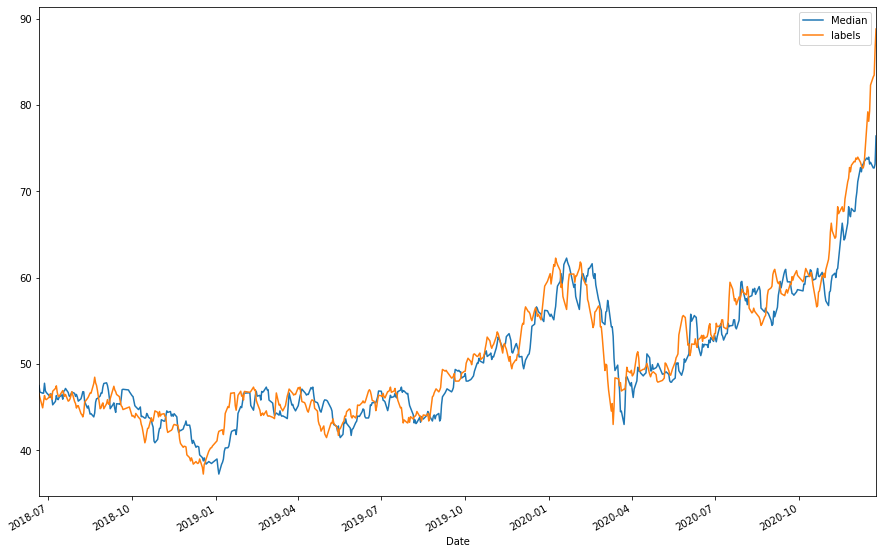

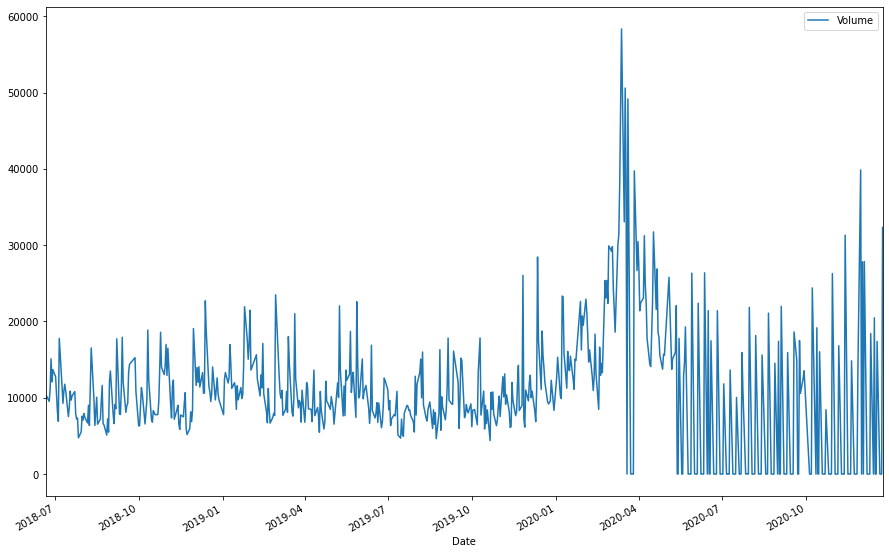

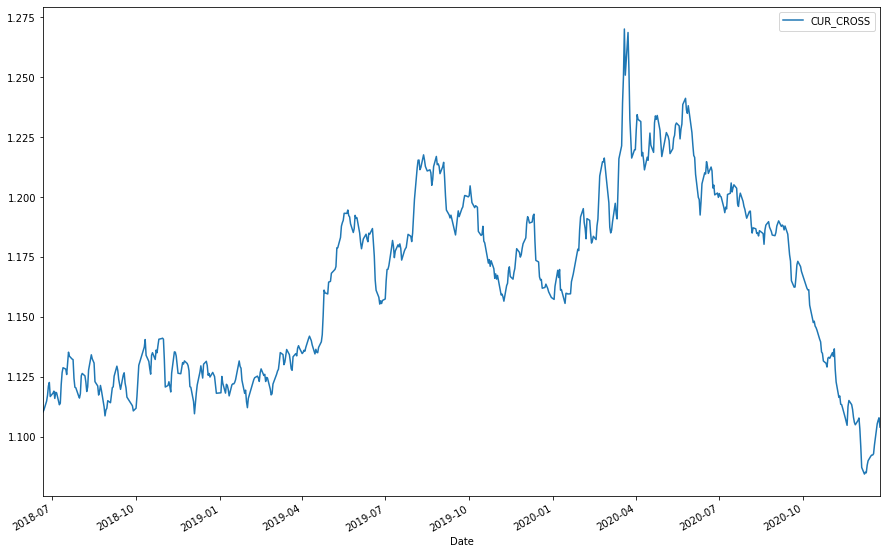

In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

ext_stock_history = sm_stk_history.copy()

ext_stock_history['USD_CLOSE'] = usd_history['Close']
ext_stock_history['USD_OPEN'] = usd_history['Open']
ext_stock_history['CNY_CLOSE'] = cny_history['Close']
ext_stock_history['CNY_OPEN'] = cny_history['Open']

ext_stock_history['CUR_CROSS'] = (usd_history['High'] + usd_history['Low']) / 2000

## data preparation 
SMA_WINDOWS = [2, 3, 5, 10, 20, 60, 120]
ext_stock_history['Median'] = (ext_stock_history['High'] + ext_stock_history['Low']) / 2

for wnd in SMA_WINDOWS:
    ext_stock_history['SMA_{}'.format(wnd)] = ext_stock_history['Median'].rolling(window=wnd).mean()

ext_stock_history['MGAP'] = (ext_stock_history['Open'][1:] - ext_stock_history['Close'][:-1]) / ext_stock_history['Close'][:-1]

def chop_seq(data, step_sz):
    trunc_sz = int(np.floor(len(data) / step_sz) - 1) * step_sz
    return [data[i:i + step_sz] for i in range(trunc_sz)]

def calc_rsi(data, period):
    keys = ['RSI_{}'.format(period), 
            'GAIN_{}'.format(period), 
            'LOSS_{}'.format(period),
            'RS_{}'.format(period)]

    open_close_price = data[['Open','Close']].to_numpy()
    gain, loss, rs_v, rsi_v = [], [], [], []
    truncated = open_close_price[:-period]
    for i, _ in enumerate(truncated):
        change = open_close_price[i : i + period][:,1] - open_close_price[i: i + period][:,0]
        avg_g = np.average(change[change > 0])
        avg_l = np.average(change[change < 0])
        rs = avg_g / np.abs(avg_l)
        rsi = 100 - 100 / (1 + rs)
        
        gain.append(avg_g)
        loss.append(avg_l)
        rs_v.append(rs)
        rsi_v.append(rsi)
    padding = [None for _ in range(period)]
    return dict(zip(keys, np.array([np.array(padding + rsi_v), np.array(padding + gain), np.array(padding + loss), np.array(padding + rs_v)], dtype=float)))

rsi_window = 15
prediction_offset = 10
prediction_target = 'Median'
n_steps = 20

rsi_data = calc_rsi(sm_stk_history, rsi_window)
for k in rsi_data:
    ext_stock_history.insert(0, k, rsi_data[k])

ext_stock_history['labels'] = np.append(ext_stock_history[prediction_target][prediction_offset:].to_numpy(), [None for _ in range(prediction_offset)]).astype(float)

ext_stock_history = ext_stock_history[ext_stock_history['Volume'] > 0]
clean_stock = ext_stock_history.dropna()

ccr = clean_stock.corr()
target_cc_factors = ccr['labels']

target_cc_factors = abs(target_cc_factors).sort_values()
input_features = list(target_cc_factors[-7:].index)
for k in ['labels']:
    if k in input_features:
        input_features.remove(k)
print(input_features)


mess_data = np.array(chop_seq(ext_stock_history[input_features].to_numpy(), n_steps))
stock_data = np.array(chop_seq(clean_stock[input_features].to_numpy(), n_steps))
refs = np.array(chop_seq(clean_stock[prediction_target].to_numpy(), n_steps))
labels = np.array(chop_seq(clean_stock['labels'].to_numpy(), 1))

clean_stock.plot(y=['Median','SMA_20', 'SMA_60'],figsize=(15,10))
clean_stock.plot(y=['RSI_15'],figsize=(15,10))
clean_stock.plot(y=['GAIN_15', 'LOSS_15'], figsize=(15,10))
clean_stock.plot(y=[prediction_target, 'labels'], figsize=(15,10))
clean_stock.plot(y=['Volume'], figsize=(15,10))
clean_stock.plot(y=['CUR_CROSS'], figsize=(15,10))
clean_stock = clean_stock.copy()

# scatter_matrix(clean_stock, figsize=(15,10))


In [1]:
import tensorflow as tf
import sys
from datetime import datetime
n_inputs = len(input_features)
batch_size = 10
n_epoch = 100
learning_rate = 1e-7
drop_rate = 0.5
n_feature_per_channel = n_steps


class SimpleBatch(collections.Iterator):
    def __init__(self, data, labels, size, normalize=False):
        self.data = data
        self.labels = labels
        self.size = size 
        self.pos = 0
        self.normalize = normalize
    
    def __iter__(self):
        self.pos = 0
        return self
        
    def __next__(self):
        if self.pos + self.size < len(self.data):
            self.pos += 1
            data, labels = self.data[self.pos: self.pos + self.size], self.labels[self.pos: self.pos + self.size]
            if self.normalize:
                return data / np.max(data), labels
            else:
                return data, labels
        raise StopIteration
        



tf.reset_default_graph()

batches = int(np.floor(len(stock_data) / batch_size))
test_size = int(np.floor(batches * 0.2)) 
train_size = (batches - test_size)
test_size *= batch_size
train_size *= batch_size
print(train_size, test_size)

train_data, test_data = stock_data[:train_size], stock_data[-test_size:]
train_labels, test_labels = labels[:train_size], labels[-test_size:]

with tf.name_scope('input'):
    X = tf.placeholder(dtype=tf.float32, shape=(None, n_steps, n_inputs))
    Y = tf.placeholder(dtype=tf.float32, shape=(None))
    training = tf.placeholder_with_default(False, shape=())


def multi_conv_channel(x, filters, 
                       kernels=[1], 
                       padding='same', 
                       activation='relu', 
                       kernel_initializer='he_uniform', 
                       kernel_regularizer=None):
    
    with tf.name_scope('frontend'):
        return tf.concat([tf.keras.layers.Conv1D(filters, 
                                                 k, 
                                                 padding=padding, 
                                                 activation=activation, 
                                                 kernel_initializer=kernel_initializer, 
                                                 kernel_regularizer=kernel_regularizer)(x) for k in kernels], axis=2)



front_conv_kernels = [1 , 3, 5, 7, 11]
conv_chns = len(front_conv_kernels)

conv_0 = multi_conv_channel(X,
                            n_feature_per_channel, 
                            activation=tf.nn.swish,
                            kernels=front_conv_kernels,
                            kernel_regularizer=tf.keras.regularizers.l2(0.01))

conv_1 = tf.keras.layers.Conv1D(n_feature_per_channel * conv_chns, 1, 
                                padding='same', 
                                activation=tf.nn.swish, 
                                kernel_initializer='he_uniform', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv_0)
mxp_1 = tf.keras.layers.MaxPooling1D(2)(conv_1)
do_1 = tf.keras.layers.Dropout(drop_rate)(mxp_1)

conv_2 = tf.keras.layers.Conv1D(n_feature_per_channel * conv_chns * 2, 
                                2, 
                                padding='same', 
                                activation=tf.nn.swish, 
                                kernel_initializer='he_uniform', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(do_1)
mxp_2 = tf.keras.layers.MaxPooling1D(2)(conv_2)
do_2 = tf.keras.layers.Dropout(drop_rate)(mxp_2)

conv_3 = tf.keras.layers.Conv1D(n_feature_per_channel * conv_chns * 3, 
                                2, 
                                padding='same', 
                                activation=tf.nn.swish, 
                                kernel_initializer='he_uniform', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(do_2)
mxp_3 = tf.keras.layers.MaxPooling1D(2)(conv_3)
do_3 = tf.keras.layers.Dropout(drop_rate)(mxp_3)

conv_4 = tf.keras.layers.Conv1D(n_feature_per_channel * conv_chns * 4, 
                                2, 
                                padding='same', 
                                activation=tf.nn.swish, 
                                kernel_initializer='he_uniform', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(do_3)
mxp_4 = tf.keras.layers.MaxPooling1D(2)(conv_4)
do_4 = tf.keras.layers.Dropout(drop_rate)(mxp_4)

conv_5 = tf.keras.layers.Conv1D(n_feature_per_channel * conv_chns * 5, 
                                2, 
                                padding='same', 
                                activation=tf.nn.swish, 
                                kernel_initializer='he_uniform', 
                                kernel_regularizer=tf.keras.regularizers.l2(0.01))(do_4)
do_5 = tf.keras.layers.Dropout(drop_rate)(conv_5)


flatten = tf.keras.layers.Flatten()(do_5)

fc_1 = tf.keras.layers.Dense(n_feature_per_channel * conv_chns * 5, 
                             kernel_initializer='he_uniform', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                             activation='relu')(flatten)
do_fc_1 = tf.keras.layers.Dropout(drop_rate)(fc_1)

fc_2 = tf.keras.layers.Dense(n_feature_per_channel * conv_chns * 2,  
                             kernel_initializer='he_uniform', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01),
                             activation='relu')(do_fc_1)
do_fc_2 = tf.keras.layers.Dropout(drop_rate)(fc_2)

fc_3 = tf.keras.layers.Dense(n_feature_per_channel * conv_chns,  
                             kernel_initializer='he_uniform', 
                             kernel_regularizer=tf.keras.regularizers.l2(0.01),
                             activation='relu')(do_fc_2)

do_fc_3 = tf.keras.layers.Dropout(drop_rate)(fc_3)

output = tf.keras.layers.Dense(1, name="prediction")(do_fc_3)

print(output.get_shape())

with tf.name_scope('eval'):
    loss = tf.reduce_mean(tf.square(Y - output))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #               tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)
    train_op = optimizer.minimize(loss)
    sb = SimpleBatch(train_data, train_labels, batch_size)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

summary_writer = tf.summary.FileWriter('/home/tf_logs/rnn_stock_v2_{}_{}_{}'.format(datetime.now().strftime("%Y%m%d_%H%M%S"), 
                                                                 batch_size,
                                                                 n_feature_per_channel), graph=tf.get_default_graph())

min_loss = sys.maxsize
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epoch):
        for x_batch, y_batch in iter(sb):
            sess.run(train_op, feed_dict={X: x_batch, Y: y_batch, training: True})
        test_loss = sess.run(loss, feed_dict={X: test_data, Y: test_labels, training: False})
        train_loss = sess.run(loss, feed_dict={X: train_data, Y: train_labels, training: False})
        summary = tf.summary.Summary()
        summary.value.add(tag='test_loss', simple_value=test_loss)
        summary.value.add(tag='train_loss', simple_value=train_loss)
        summary_writer.add_summary(summary, epoch)
        if min_loss > test_loss and train_loss < 200:
            saver.save(sess, '/home/tf_logs/rnn_stock_v2.ckpt')
            min_loss = test_loss
            optimal_pred = sess.run(output, feed_dict={X:stock_data})
        else:
            pred = sess.run(output, feed_dict={X:stock_data})
        print(epoch, test_loss, train_loss)
    
summary_writer.close()

NameError: name 'input_features' is not defined

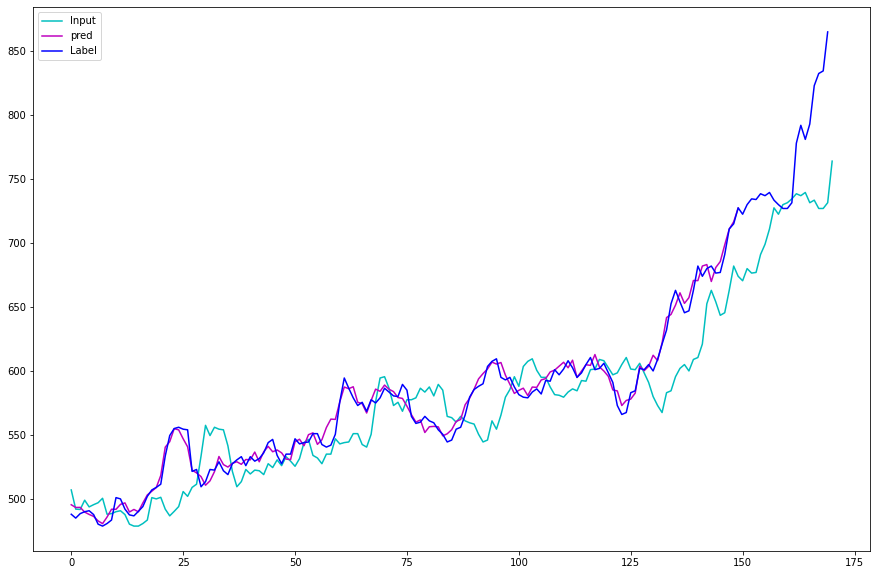

In [145]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(15,10))
plt.plot(clean_stock['Median'].to_numpy()[450:], c='c', label='Input')
pred = np.reshape(pred,(-1,))
optimal_pred = np.reshape(optimal_pred,(-1,))
plt.plot(pred[450:],c='m', label='pred')
# plt.plot(optimal_pred,c='r', label='opt predicted')
plt.plot(labels[450:],c='b',label='Label')
plt.legend()
plt.show()



In [77]:
import tensorflow as tf
# restore model and test performance over test set
tf.reset_default_graph()

saver = tf.train.import_meta_graph('/home/tf_logs/rnn_stock_v2.ckpt.meta')
ops = tf.get_default_graph().get_operations()
print(ops)
with tf.Session() as sess:
    saver.restore(sess, '/home/tf_logs/rnn_stock_v2.ckpt')
    sess.run(output)
    
    

OSError: File /home/tf_logs/rnn_stock_v2.ckpt.meta does not exist.